#1. 흐름 이해하기

## 1.1 Streamlit 이해

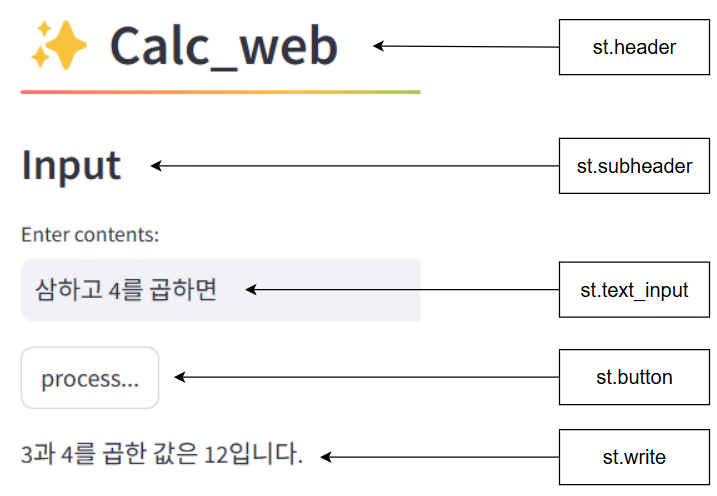

# 2. 코드 이해하기

## 2.1 초기화

### 2.1.1 라이브러리 설치

In [1]:
!pip install --upgrade --quiet \
    "google-cloud-aiplatform[langchain,reasoningengine]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.1/420.1 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.7/153.7 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 25.9 MB/s eta 0:00:00


In [2]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### 2.1.2 환경변수 설정 및 vertexai 초기화

In [1]:
import os

PROJECT_ID = os.environ.get("GOOGLE_CLOUD_PROJECT")
LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")
STAGING_BUCKET=f"gs://jin62-staging-{PROJECT_ID}"
STAGING_BUCKET

'gs://jin62-staging-gemini-demo-450807'

In [2]:
!gcloud storage buckets create $STAGING_BUCKET

Creating gs://jin62-staging-gemini-demo-450807/...
ERROR: (gcloud.storage.buckets.create) HTTPError 409: Your previous request to create the named bucket succeeded and you already own it.


In [3]:
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION, staging_bucket=STAGING_BUCKET)

## 2.2 함수 제작

In [4]:
def sum(a: int, b: int):
  """
  두 수를 입력받아 더하는 함수 입니다.
  """
  return a+b

## 2.3 Agent Engine(Reasoning Engine)

### 2.3.1 Engine 생성

In [6]:
from vertexai.preview import reasoning_engines

In [39]:
system_instruction="""
너는 덧셈과 곱셈을 처리하는 agent이다.
덧셈은 주어진 함수를 이용한다.
곱셈은 덧셈 함수를 여러번 반복한다.
"""

In [40]:
agent = reasoning_engines.LangchainAgent(
    "gemini-2.0-flash",
    tools=[sum],
    system_instruction=system_instruction
)

## 2.3.2 Query

In [41]:
agent.query(input="십 더하기 20")

{'input': '십 더하기 20', 'output': '10 더하기 20은 30입니다.\n'}

In [42]:
agent.query(input="삼 곱하기 3")

{'input': '삼 곱하기 3',
 'output': '3 더하기 3은 6입니다. 6 더하기 3은 9입니다. 따라서 3 곱하기 3은 9입니다.'}

In [43]:
agent.query(input="오 곱하기 칠은?")

{'input': '오 곱하기 칠은?', 'output': '오 곱하기 칠은 35입니다.'}

## 2.4 배포

### 2.4.1 agent 생성

In [44]:
remote_agent = reasoning_engines.ReasoningEngine.create(
    agent,
    requirements=[
         "google-cloud-aiplatform[langchain,reasoningengine]"
    ]
)

INFO:vertexai.reasoning_engines._reasoning_engines:Using bucket jin62-staging-gemini-demo-450807
INFO:vertexai.reasoning_engines._reasoning_engines:Writing to gs://jin62-staging-gemini-demo-450807/reasoning_engine/reasoning_engine.pkl
INFO:vertexai.reasoning_engines._reasoning_engines:Writing to gs://jin62-staging-gemini-demo-450807/reasoning_engine/requirements.txt
INFO:vertexai.reasoning_engines._reasoning_engines:Creating in-memory tarfile of extra_packages
INFO:vertexai.reasoning_engines._reasoning_engines:Writing to gs://jin62-staging-gemini-demo-450807/reasoning_engine/dependencies.tar.gz
INFO:vertexai.reasoning_engines._reasoning_engines:Creating ReasoningEngine
INFO:vertexai.reasoning_engines._reasoning_engines:Create ReasoningEngine backing LRO: projects/741782101329/locations/us-central1/reasoningEngines/3065552767448776704/operations/929081930991796224
INFO:vertexai.reasoning_engines._reasoning_engines:ReasoningEngine created. Resource name: projects/741782101329/locations/u

### 2.4.2 Query

In [45]:
ENGINE_ID = f"{remote_agent.resource_name.split('/')[-1]}"
remote_app = reasoning_engines.ReasoningEngine(ENGINE_ID)

In [46]:
response = remote_app.query(input="십 더하기 10")
response

{'input': '십 더하기 10', 'output': '20입니다.\n'}

In [47]:
response = remote_app.query(input="오 곱하기 칠은?")
response

{'input': '오 곱하기 칠은?', 'output': '오 곱하기 칠은 35입니다.'}

### 2.5 Reasoing Engine 삭제

In [48]:
for re in reasoning_engines.ReasoningEngine.list():
  remote_app = reasoning_engines.ReasoningEngine(re.name)
  remote_app.delete()

INFO:google.cloud.aiplatform.base:Deleting ReasoningEngine : projects/gemini-demo-450807/locations/us-central1/reasoningEngines/3065552767448776704
INFO:google.cloud.aiplatform.base:ReasoningEngine deleted. . Resource name: projects/gemini-demo-450807/locations/us-central1/reasoningEngines/3065552767448776704
INFO:google.cloud.aiplatform.base:Deleting ReasoningEngine resource: projects/gemini-demo-450807/locations/us-central1/reasoningEngines/3065552767448776704
INFO:google.cloud.aiplatform.base:Delete ReasoningEngine backing LRO: projects/741782101329/locations/us-central1/operations/7896150554533953536
INFO:google.cloud.aiplatform.base:ReasoningEngine resource projects/gemini-demo-450807/locations/us-central1/reasoningEngines/3065552767448776704 deleted.


## 2.6 GCS에서 모델 연동하기

In [49]:
from google.cloud import storage
import pickle

In [50]:
def load_reasoning_engine_from_gcs(bucket_name: str, blob_name: str):
    """
    GCS에 저장된 pkl 파일을 로드하여 ReasoningEngine 객체를 반환합니다.
    """
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)

    # pkl 파일 다운로드 및 로드
    with blob.open("rb") as f:
        loaded_engine = pickle.load(f)
    return loaded_engine

In [51]:
BUCKET_NAME = "jin62-staging-gemini-demo-450807"  # 실제 버킷 이름으로 변경
BLOB_NAME = "reasoning_engine/reasoning_engine.pkl"  # 실제 pkl 파일 경로로 변경

In [52]:
# ReasoningEngine 로드
loaded_engine = load_reasoning_engine_from_gcs(BUCKET_NAME, BLOB_NAME)

In [53]:
# ReasoningEngine 사용
prompt = "삼과 4를 더하면?"
response = loaded_engine.query(input=prompt)
print(f"응답: {response}")

응답: {'input': '삼과 4를 더하면?', 'output': '3 더하기 4는 7입니다.\n'}


In [56]:
# ReasoningEngine 사용
prompt = "오 빼기 칠은?"
response = loaded_engine.query(input=prompt)
print(f"응답: {response}")

응답: {'input': '오 빼기 칠은?', 'output': '뺄셈은 지원하지 않습니다. 덧셈만 가능합니다.'}


In [55]:
# ReasoningEngine 사용
prompt = "4 더하기 10 곱하기 4?"
response = loaded_engine.query(input=prompt)
print(f"응답: {response}")

응답: {'input': '4 더하기 10 곱하기 4?', 'output': '4 더하기 10 곱하기 4는 44입니다.'}


# 3. streamlit으로 배포하기

## 3.1 환경 설정

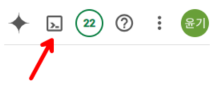

오른쪽 상단의 terminal을 실행한다.

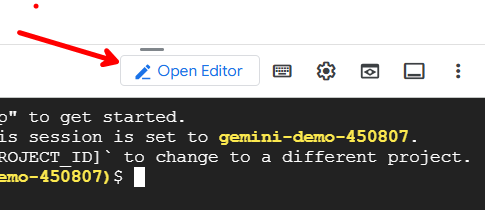

열린 terminal에서 "Open Editor"를 click한다.

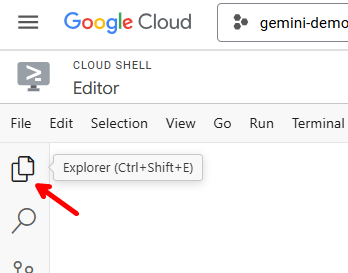

나타난 Editor창에서 Explorer를 실행한다.

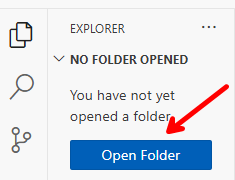

open folder를 click하면 다음과 같은 화면이 나타난다.

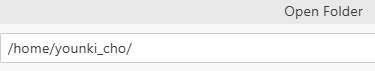

OK를 누르고 folder가 열리길 기다린다.

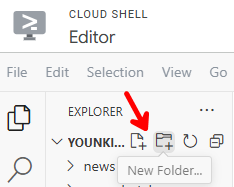

explorer의 root folder에 마우스를 올리면 위와 같이 "new folder"가 나타난다.

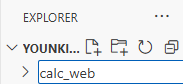

위와 같이 calc_web이라고 폴더를 만든다.

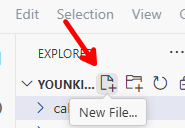

이번에는 "New File"를 클릭해서 app.py라는 파일을 만든다. 이와 같은 방법으로 Dockerfile과 requirements.txt 파일을 만든다. 각 코드는 github을 참조한다.

## 3.2 Image 만들기

### 3.2.1 환경변수 설정



```
PROJECT_ID="gemini-demo-450807" # 프로젝트 ID로 설정
REGION="us-central1" # 리전으로 설정 (예: us-central1)
IMAGE_NAME="calc-web" # 이미지 이름으로 설정
IMAGE_URI="${REGION}-docker.pkg.dev/${PROJECT_ID}/${IMAGE_NAME}/${IMAGE_NAME}:latest" # 이미지 URI 설정
```



### 3.2.2 이미지 생성

```
docker build -t ${IMAGE_URI} .
```

### 3.2.3 테스트

```
docker run -p 8080:8080 $IMAGE_URI
```

## 3.3 Artifacts repository에 등록하기

### 3.3.1 Repository 생성

```
gcloud artifacts repositories create $IMAGE_NAME \
		    --repository-format=DOCKER \
		    --location=$REGION \
		    --project=$PROJECT_ID
```

3.3.2 Image upload

```
docker push ${IMAGE_URI}
```

## 3.4 Cloud run 배포

```
SERVICE_NAME="$IMAGE_NAME-service"

gcloud run deploy ${SERVICE_NAME} \
    --image ${IMAGE_URI} \
    --platform managed \
    --region ${REGION} \
    --project=$PROJECT_ID \
    --allow-unauthenticated
```

# 4. 정리

## 4.1 Cloud Run 삭제

```
gcloud run services delete ${SERVICE_NAME} \
	    --region ${REGION} \
	    --project=$PROJECT_ID
```

## 4.2 Artifacts repository 삭제

```
gcloud artifacts repositories delete $IMAGE_NAME \
    --location=$REGION \
    --project=$PROJECT_ID
```

## 4.3 docker image 삭제

```
docker rmi -f ${IMAGE_URI}
```

## 4.4 GCS 삭제

```
gcloud storage rm -r $STAGING_BUCKET
```

# 5. Reference

* https://cloud.google.com/vertex-ai/generative-ai/docs/reference/python/latest/vertexai.preview.reasoning_engines.ReasoningEngine
* https://cloud.google.com/vertex-ai/generative-ai/docs/reasoning-engine/manage?hl=ko
* https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/reasoning-engine#generativeaionvertexai_get_reasoning_engine-python_vertex_ai_sdk

